## Asignment: Computer vison course
- Alumno 1: Daniel Carmona Pedrajas
- Alumno 2: Joel Pardo Ferrera

The goals of this assignment are:
+ Develop proficiency in using Tensorflow/Keras for training neural nets (NNs).
+ Put in practice Unit 4 knowledge to optimize the parameters and architecture of a feed-forward Neural Net (ffNN), in the context of a computer vision problem.
+ Use NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (cNN).

Follow the link above to download the classification benchmark termed “xview_recognition”: [https://drive.upm.es/s/c4gfDOOwWfPdm0z](https://drive.upm.es/s/c4gfDOOwWfPdm0z")

In [1]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
tf.device('/device:GPU.0')
tf.__version__

'2.10.0'

In [2]:
IMAGES_PATH = "../../../ImagenesPractica/xview_recognition/"
MODELS_PATH = "../Models/"
MODELS_HISTORY_PATH = f"{MODELS_PATH}models_history.csv"
MODELS_IMAGES_PATH = f"{MODELS_PATH}ModelsImages/"
RESULTS_IMAGES_PATH = "../ResultsImages/"

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {13: 'CARGO_PLANE', 
              15: 'HELICOPTER', 
              18: 'SMALL_CAR', 
              19: 'BUS', 
              23: 'TRUCK', 
              41: 'MOTORBOAT', 
              47: 'FISHING_VESSEL', 
              60: 'DUMP_TRUCK', 
              64: 'EXCAVATOR', 
              73: 'BUILDING',
              86: 'STORAGE_TANK', 
              91: 'SHIPPING_CONTAINER'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False, do_augmentate=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                loaded_image = load_geoimage(filename)
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories, model_name, normalize=False):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)
    fig.savefig(f"{RESULTS_IMAGES_PATH}cm_{model_name}.png")

## Training
Design and train a ffNN to deal with the xview_recognition classification task

In [7]:
import json

DATA_AUGMENTATION = True
if DATA_AUGMENTATION:
    json_file = f'{IMAGES_PATH}xview_ann_train_augmented.json'
else:
    # Load database
    json_file = f'{IMAGES_PATH}xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGES_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    if counts[obj.category] >= 4000:
        continue
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
    
print(counts)

{'CARGO_PLANE': 4000, 'HELICOPTER': 392, 'SMALL_CAR': 4000, 'BUS': 4000, 'TRUCK': 4000, 'MOTORBOAT': 4000, 'FISHING_VESSEL': 4000, 'DUMP_TRUCK': 4000, 'EXCAVATOR': 4000, 'BUILDING': 4000, 'STORAGE_TANK': 4000, 'SHIPPING_CONTAINER': 4000}


In [9]:
from sklearn.model_selection import train_test_split
anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.utils.vis_utils import plot_model
from keras.initializers import HeUniform, HeNormal
from keras.regularizers import L1, L2

exp = "-3-3-1"
ACTIVATION = "relu"
DROPOUT = "0.2"
REGULARIZATION = "L2 0.00001"
INITIALIZER = "HeUniform"
BATCH_NORMALIZATION = "Yes"

def initial_model1():
    print('Load model')
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    model.add(Activation(ACTIVATION))
    model.add(Dropout(0.2))
    model.add(Dense(len(categories)))
    model.add(Activation('softmax'))
    model_name = f"ir_12{exp}"
    return model, model_name

def ffnn_architecture2():
    print('Load model')
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [256, 128, 64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
                        
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_256_128_64_32{exp}"
    return model, model_name

def ffnn_architecture3():
    print("Load model")
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [512, 128, 32]
    
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
                        
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_512_128_32{exp}"
    return model, model_name


def ffnn_architecture4():
    print("Load model")
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
                        
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model_name = f"ir_64_32{exp}"
    return model, model_name


def ffnn_architecture5():
    print("Load model")
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [1024, 256]
    
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
                        
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_1024_256{exp}"
    return model, model_name

def conv_architecture6():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-64_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture7():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     strides=1,
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     input_shape=(224,224,3)))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-128_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture8():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same",
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-128_maxpool2_conv3x3-64_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture9():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same",
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-64_maxpool2_conv3x3-128_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture10():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same",
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=256, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-64_maxpool2_conv3x3-128_maxpool2_conv3x3-256_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture11():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same",
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=256, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=512, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Conv2D(filters=1024, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-128_maxpool2_conv3x3-256_maxpool2_conv3x3-512_maxpool2_conv3x3-512_maxpool2_64_32{exp}"
    return model, model_name

def conv_architecture12():
    print("Load model")
    model = Sequential()
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same",
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3),
                     kernel_initializer=HeUniform(seed=None),
                     kernel_regularizer=L2(0.00001),
                     strides=1,
                     padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    convs = [256, 512]
    for c in convs:
        model.add(Conv2D(filters=c, 
                         kernel_size=(3, 3),
                         kernel_initializer=HeUniform(seed=None),
                         kernel_regularizer=L2(0.00001),
                         strides=1,
                         padding="same"))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        
        model.add(Conv2D(filters=c, 
                         kernel_size=(3, 3),
                         kernel_initializer=HeUniform(seed=None),
                         kernel_regularizer=L2(0.00001),
                         strides=1,
                         padding="same"))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
    
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    
    model.add(Flatten())
    
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L2(0.00001)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L2(0.00001)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model_name = f"ir_conv3x3-128-128_maxpool2_conv3x3-256-256_maxpool2_conv3x3-512-512_maxpool2_64_32{exp}"
    return model, model_name

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                             

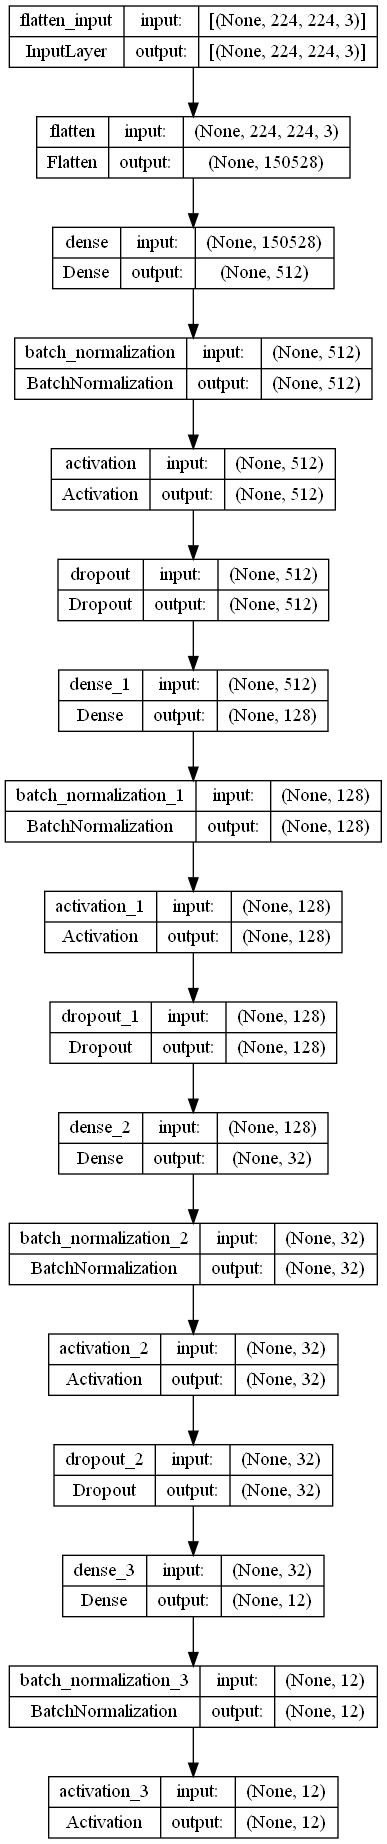

In [11]:
# Load architecture
model, model_name = ffnn_architecture3()
model.summary()
plot_model(model, to_file=f"{MODELS_IMAGES_PATH}{model_name}.png", show_shapes=True, show_layer_names=True)

In [12]:
# Learning rate is changed to 0.001
from keras.optimizers import Adam
OPTIMIZER_NAME = "Adam 0.9 0.999"
LEARNING_RATE = 0.1
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Callbacks
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint(f'{MODELS_PATH}{model_name}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]
CALLBACKS_NAMES = "reducelr 5 0.1 - early_stop 20"

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
BATCH_SIZE = 64
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

In [15]:
import math
import numpy as np
import time

print('Training model')
N_EPOCHS = 50
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

start_time = time.perf_counter()

h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=N_EPOCHS, callbacks=callbacks, verbose=1)

end_time = time.perf_counter()
TRAINING_TIME = round(end_time - start_time)

# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model


C:\Users\Daniel\AppData\Local\Temp\ipykernel_1944\3526262076.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=N_EPOCHS, callbacks=callbacks, verbose=1)


Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/dense/kernel/Regularizer/mul' defined at (most recent call last):
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Daniel\AppData\Local\Temp\ipykernel_1944\3526262076.py", line 12, in <module>
      h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=N_EPOCHS, callbacks=callbacks, verbose=1)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/dense/kernel/Regularizer/mul'
failed to allocate memory
	 [[{{node gradient_tape/dense/kernel/Regularizer/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2853]

In [ ]:
import pandas as pd
results=pd.DataFrame(h.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig(f"{RESULTS_IMAGES_PATH}tr_{model_name}.png")
plt.show()

In [ ]:
h.history

In [ ]:
import json
# Load database
json_file = f'{IMAGES_PATH}xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGES_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [ ]:
import numpy as np
import keras
model = keras.models.load_model(f'{MODELS_PATH}{model_name}.hdf5')
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories, model_name, normalize=True)

In [ ]:
import numpy as np
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)

MEAN_ACCURACY = (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100)
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
MEAN_RECALL = (acc.mean() * 100)
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
MEAN_PRECISION = (acc.mean() * 100)

print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

## Save results

In [ ]:
import pandas as pd
history_df = pd.read_csv(MODELS_HISTORY_PATH, index_col = 0)

In [ ]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'optimizer',
    'activation',
    'batch_size',
    'callbacks',
    'regularization',
    'initializer',
    'dropout',
    'batch_normalization',
    'mean_accuracy',
    'mean_recall',
    'mean_precision',
    'training_time',
    'data_augmentation'
]

new_history = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    OPTIMIZER_NAME,
    ACTIVATION,
    BATCH_SIZE,
    CALLBACKS_NAMES,
    REGULARIZATION,
    INITIALIZER,
    DROPOUT,
    BATCH_NORMALIZATION,
    MEAN_ACCURACY,
    MEAN_RECALL,
    MEAN_PRECISION,
    TRAINING_TIME,
    DATA_AUGMENTATION
    ]]

new_history_df = pd.DataFrame(new_history, columns=COLUMNS)

In [ ]:
concatenation = pd.concat([history_df, new_history_df], ignore_index=True)
concatenation.to_csv(MODELS_HISTORY_PATH)

In [ ]:
concatenation.tail()